# How is the architecture impacting the model performance?


In [2]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from aimanager.utils.utils import make_dir
from aimanager.utils.merge import merge_files_by_name

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

run = 'graph_2'

folder = f'../../data/training/{run}/train'
merged_folder = f'../../data/training/{run}/merged'
bs_folder = f'../../data/training/baselines/train'
bs_merged_folder = f'../../data/training/baselines/merged'

plot_folder = f'plots/{run}'

make_dir(plot_folder)
make_dir(merged_folder)
make_dir(bs_merged_folder)

In [3]:
# file_names = ['metrics.parquet', 'confusion_matrix.parquet', 'synthetic_predicitions.parquet']
file_names = ['metrics.parquet']


def get_df(file_name, merged_folder, folder):
    m_file = os.path.join(merged_folder, file_name)
    if not os.path.isfile(m_file):
        df = merge_files_by_name(folder, file_name)
        df.to_parquet(m_file)
        return df
    else:
        return pd.read_parquet(m_file)

metrics_df, = (
    get_df(file_name, merged_folder, folder)
    for file_name in file_names
)
metrics_df = metrics_df.reset_index(drop=True)

baseline_df = get_df(file_names[0], bs_merged_folder, bs_folder)

In [4]:
baseline_df

,baseline,name,value,cv_split,epoch,set,strategy
0,onehot_mlp_graph_2,loss,3.050371,0,0,None,None
1,onehot_mlp_graph_2,mean_absolute_error,7.843695,0,0,train,greedy
2,onehot_mlp_graph_2,accuracy,0.024625,0,0,train,greedy
3,onehot_mlp_graph_2,mean_absolute_error,7.878100,0,0,train,sampling
4,onehot_mlp_graph_2,accuracy,0.048376,0,0,train,sampling
...,...,...,...,...,...,...,...
17995,onehot_mlp_graph,accuracy,0.346140,19,990,train,sampling
17996,onehot_mlp_graph,mean_absolute_error,2.747573,19,990,test,greedy
17997,onehot_mlp_graph,accuracy,0.538835,19,990,test,greedy
17998,onehot_mlp_graph,mean_absolute_error,3.834951,19,990,test,sampling


In [5]:
labels = list(set(metrics_df.columns) - set(['name', 'value', 'cv_split', 'epoch', 'set']))
print(labels)

metrics_df['label'] = ''
bw = ''
for l in labels:
    metrics_df['label'] += (bw + l + ':') + metrics_df[l].astype(str)
    bw = ' '

to_string = ['layers', 'hidden_size']
to_string = list(set(to_string).intersection(set(metrics_df.columns)))
if len(to_string) > 0:
    metrics_df[to_string] = metrics_df[to_string].astype(str)
    # synthethetic_df[to_string] = synthethetic_df[to_string].astype(str)
    # confusion_matrix_df[to_string] = confusion_matrix_df[to_string].astype(str)

['hidden_size', 'model', 'weight_decay', 'strategy']


In [6]:
w = (
    (baseline_df['set'] == 'test') & 
    (baseline_df['epoch'] == 990) & 
    (baseline_df['strategy'] == 'greedy') & 
    (baseline_df['baseline'] == 'onehot_mlp_graph_3') 
)

df = baseline_df[w]

baseline = df.groupby(['baseline', 'name'])['value'].median()
baseline

baseline            name               
onehot_mlp_graph_3  accuracy               0.445015
                    mean_absolute_error    3.030357
Name: value, dtype: float64

## Overview

In [7]:
metric_name = 'loss'

w1 = (
    (metrics_df['set'] == 'test') & 
    (metrics_df['strategy'] == 'greedy') & 
    (metrics_df['epoch'] == 990)
)

w2 = (metrics_df['name'] == metric_name)
df = metrics_df[w1 & w2]



df = df.sort_values(labels)
sns.catplot(data=df, x='value', y='label', orient='h', kind='box', sharex=False, height=12)

for idx, dfg in baseline.groupby(level=0):
    plt.axvline(dfg[(idx, metric_name)], color='black', ls='--')
    plt.text(dfg[(idx, metric_name)], 0.5, idx, rotation=90, size=16, va='center')

ValueError: min() arg is an empty sequence

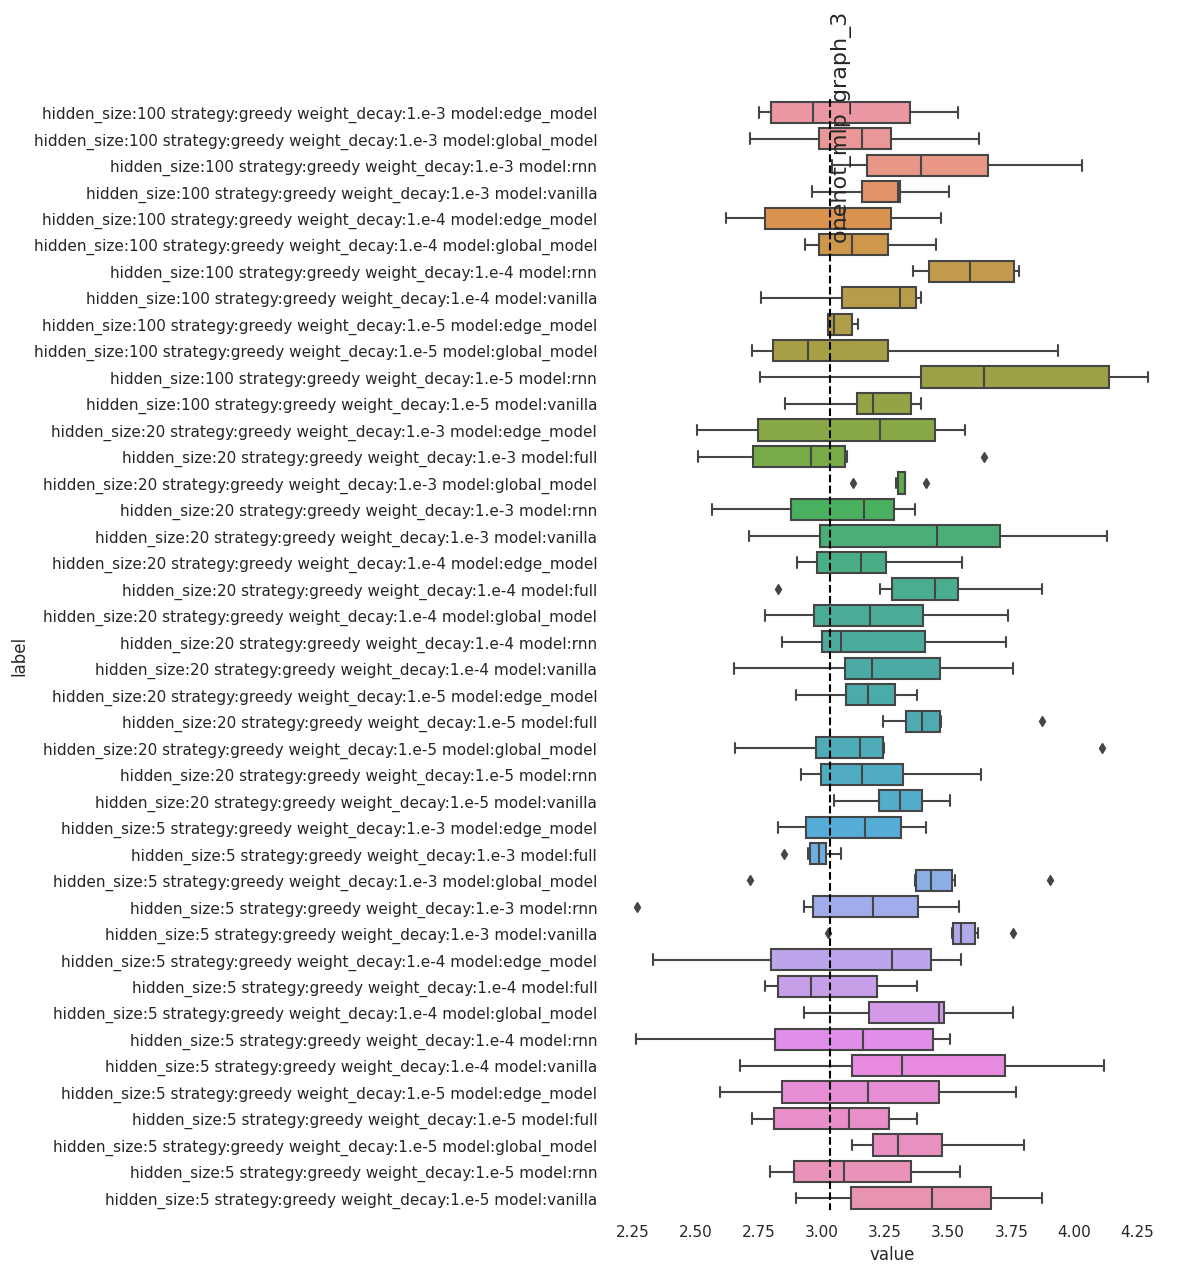

In [ ]:
metric_name = 'mean_absolute_error'
w2 = (metrics_df['name'] == metric_name)
df = metrics_df[w1 & w2]

df = df.sort_values(labels)
sns.catplot(data=df, x='value', y='label', orient='h', kind='box', sharex=False, height=12)

for idx, dfg in baseline.groupby(level=0):
    plt.axvline(dfg[(idx, metric_name)], color='black', ls='--')
    plt.text(dfg[(idx, metric_name)], 0.5, idx, rotation=90, size=16, va='center')

### First conclusion

* Hugh variance in the performance
* Numeric encoding has clearly lower performance

## Statistical analysis of grid

In [ ]:
label_ref = {
    # 'fraction_training': 1,
    'regularisation': 'none',
    'layers': 2,
    'hidden_size': 5,
    'lr': '1.e-4'
}

label_str = [f"C({l}, Treatment(reference='{label_ref[l]}'))" if l in label_ref else l for l in labels]

In [ ]:
w = (
    (metrics_df['name'] == 'accuracy') &
    (metrics_df['set'] == 'test') &
    (metrics_df['strategy'] == 'greedy') & 
    # (metrics_df['layers'] == '2') & 
    (metrics_df['epoch'] == 990)
)
df = metrics_df[w]

m_str = [f'{a}*{b}' for a in label_str for b in label_str]

# results = smf.glm(f"value ~ {'+'.join(m_str)}", data=df).fit()
results = smf.glm(f"value ~ {'+'.join(label_str)}", data=df).fit()
results_df = results.summary2().tables[1]

print('metric accuracy - positive coef -> better')
results_df[results_df['P>|z|'] < 0.80].sort_values('P>|z|')


metric accuracy - positive coef -> better


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,0.432495,0.009992,43.284552,0.000000,0.412911,0.452079
model[T.rnn],-0.027376,0.010379,-2.637643,0.008348,-0.047719,-0.007034
model[T.vanilla],-0.017938,0.010379,-1.728245,0.083944,-0.038280,0.002405
model[T.global_model],-0.015192,0.010379,-1.463706,0.143274,-0.035535,0.005151
model[T.full],-0.012669,0.011891,-1.065437,0.286678,-0.035974,0.010637
weight_decay[T.1.e-5],-0.007212,0.008322,-0.866635,0.386142,-0.023522,0.009098


### Accuracy

#### Strong evidence
* larger learning rate (1.e-3) is better
* ordinal x encoding (and to a lesser extend onehot) is better then numeric encoding
* higher number of neurons is better for onehot encodingß

In [ ]:
w = (
    (metrics_df['name'] == 'mean_absolute_error') &
    (metrics_df['set'] == 'test') &
    (metrics_df['strategy'] == 'greedy') &
    (metrics_df['epoch'] == 990)
)
df = metrics_df[w]

m_str = [f'{a}*{b}' for a in label_str for b in label_str]

# results = smf.glm(f"value ~ {'+'.join(m_str)}", data=df).fit()
results = smf.glm(f"value ~ {'+'.join(label_str)}", data=df).fit()
results_df = results.summary2().tables[1]

print('metric mean_absolute_error - negative coef -> better')
results_df[results_df['P>|z|'] < 0.50].sort_values('Coef.')

metric mean_absolute_error - negative coef -> better


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
weight_decay[T.1.e-5],0.044991,0.054189,0.830258,0.406393,-0.061218,0.151199
model[T.global_model],0.137831,0.067585,2.039367,0.041413,0.005366,0.270296
model[T.rnn],0.156123,0.067585,2.310014,0.020887,0.023658,0.288588
model[T.vanilla],0.204423,0.067585,3.024660,0.002489,0.071958,0.336888
Intercept,3.082826,0.065064,47.381228,0.000000,2.955302,3.210349


### mean absolute error

#### Strong evidence
* ordinal > numeric
* hidden 20 > hidden 5

## Best parameters

In [ ]:
# w = (
#     (metrics_df['x_encoding'] == 'numeric')
# )
# df = metrics_df[w]
df = metrics_df

best_labels = {}
for m in ['mean_absolute_error', 'accuracy']:
    df = df.reset_index(drop=True)
    gb_col = list(set(df.columns) - set(['cv_split', 'value']))
    df_g = df.groupby(gb_col)['value'].median().reset_index()
    df_g = df_g.dropna(subset='value')
    w = (
        (df_g['name'] == m) &
        (df_g['set'] == 'test')
    )
    if m == 'mean_absolute_error':
        best = df_g.loc[df_g[w]['value'].idxmin()]
    else:
        best = df_g.loc[df_g[w]['value'].idxmax()]
    best_labels[m] = {l: best[l] for l in labels}

    print(f'Best performance for metric {m} is {best.label}.')
    w = (
        (df_g['label'] == best.label) &
        (df_g['epoch'] == 990)
    )

    print(df_g.loc[w, ['name', 'set', 'value']])
    print('================')
    # print(f'Best performance for metric {m} with a value of {best.value} is {best.label} in epoch {best.epoch}')



Best performance for metric mean_absolute_error is hidden_size:100 strategy:greedy weight_decay:1.e-3 model:edge_model.
                      name    set     value
33264             accuracy   test  0.437675
33265  mean_absolute_error   test  2.965779
33432             accuracy  train  0.468134
33433  mean_absolute_error  train  2.954039
Best performance for metric accuracy is hidden_size:20 strategy:greedy weight_decay:1.e-5 model:rnn.
                      name    set     value
33314             accuracy   test  0.431679
33315  mean_absolute_error   test  3.160557
33482             accuracy  train  0.547221
33483  mean_absolute_error  train  2.616713


### Summary

* We have the highest accuracy and mae for
    * low regularisation 
    * hidden_size of 20
    * learning rate of 1.e-3
    * x-encoding onehot
* 3 layer is leading to a better mae, 2 layer to a higher accuracy

## Investigation of particular parameter

### Hidden Size and number of layer

In [ ]:
best_labels['accuracy']

{'hidden_size': '20',
 'strategy': 'greedy',
 'weight_decay': '1.e-5',
 'model': 'rnn'}

strategy=greedy|weight_decay=1.e-5|epoch=1990


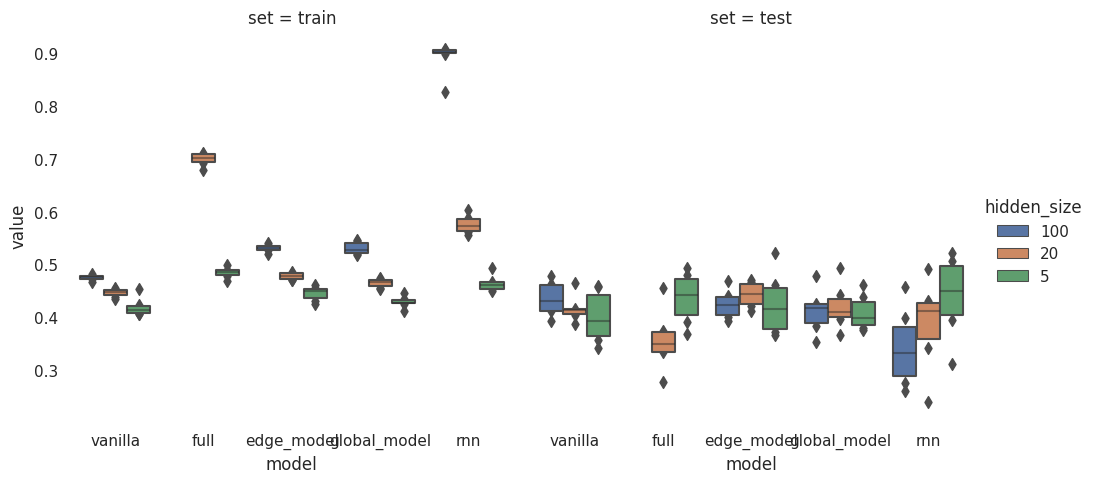

In [ ]:
selection = {'hidden_size': '5',
 'strategy': 'greedy',
 'weight_decay': '1.e-5',
 'model': 'rnn',
 'set': 'test',
 'epoch':  metrics_df['epoch'].max()
 }


focus = ['model', 'hidden_size', 'set']
metric_name = 'accuracy'

for f in focus:
    selection.pop(f)

w1 = pd.concat(
    (metrics_df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

w2 = (
    (metrics_df['name'] == metric_name) 
)

fg = sns.catplot(data=metrics_df[w1 & w2].copy(), x=focus[0], hue=focus[1] if len(focus) >= 2 else None, y='value', col=focus[2] if len(focus) >= 3 else None, row=focus[3] if len(focus) >= 4 else None, kind='boxen')


print('|'.join(f'{k}={v}' for k, v in selection.items()))

strategy=greedy|weight_decay=1.e-5|epoch=1990


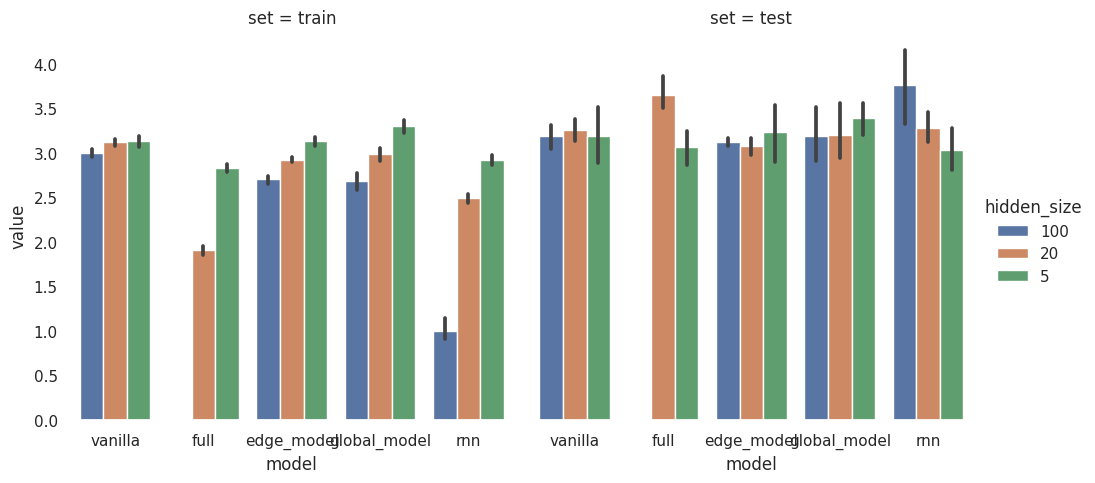

In [ ]:
selection = {'hidden_size': '5',
 'strategy': 'greedy',
 'weight_decay': '1.e-5',
 'model': 'rnn',
 'set': 'test',
 'epoch':  metrics_df['epoch'].max()
 }


focus = ['model', 'hidden_size', 'set']
metric_name = 'mean_absolute_error'

for f in focus:
    selection.pop(f)

w1 = pd.concat(
    (metrics_df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

w2 = (
    (metrics_df['name'] == metric_name) 
)

fg = sns.catplot(data=metrics_df[w1 & w2].copy(), x=focus[0], hue=focus[1] if len(focus) >= 2 else None, y='value', col=focus[2] if len(focus) >= 3 else None, kind='bar')


print('|'.join(f'{k}={v}' for k, v in selection.items()))

#### Results

* Number of layers has a relative small effect on mae
* Number of hidden units has a large effect on the training set and a small effect on the test set (overfitting!)

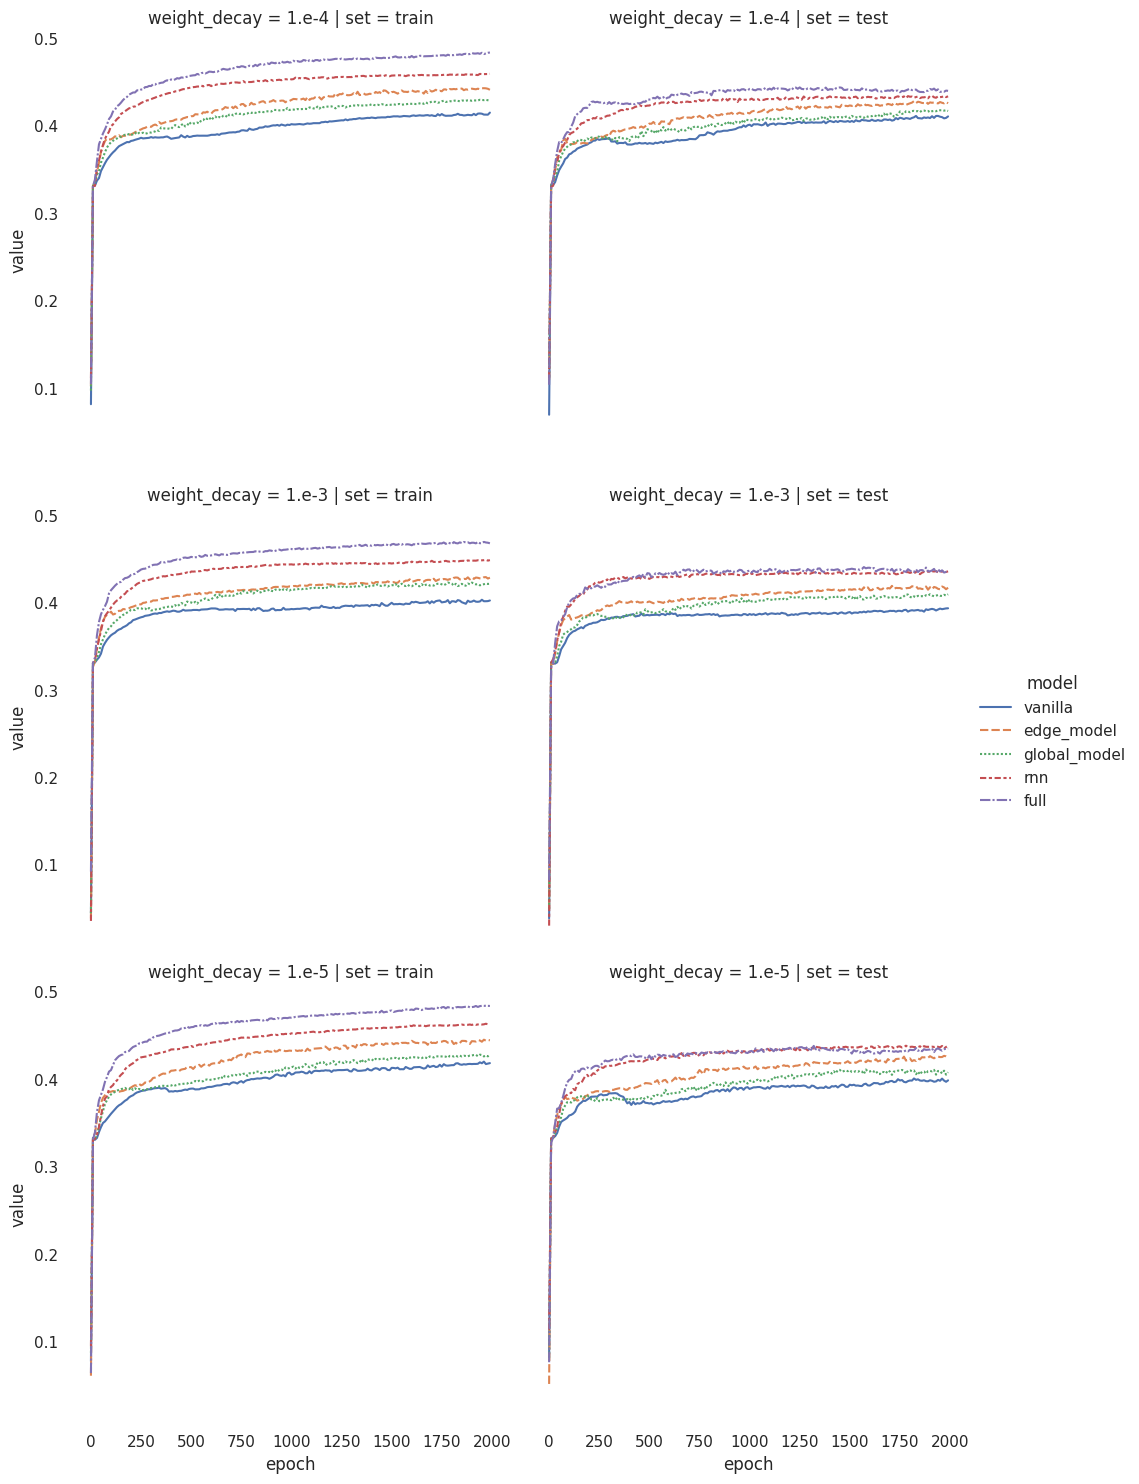

In [ ]:
metric_name = 'accuracy'

# selection = best_labels[metric_name].copy()

selection = {
    'strategy': 'greedy',
    'hidden_size': '5',
    'model': 'rnn',
    'weight_decay': '1.e-4'
}

focus = ['model', 'model', 'weight_decay']

for f in focus:
    if f in selection:
        selection.pop(f)


w1 = pd.concat(
    (metrics_df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

w2 = (
    (metrics_df['name'] == metric_name) 
)

fg = sns.relplot(data=metrics_df[w1 & w2].copy(), x='epoch', hue=focus[0], style=focus[1] if len(focus) >= 2 else None, y='value', col='set', row=focus[2] if len(focus) >= 3 else None, kind='line', ci=None)

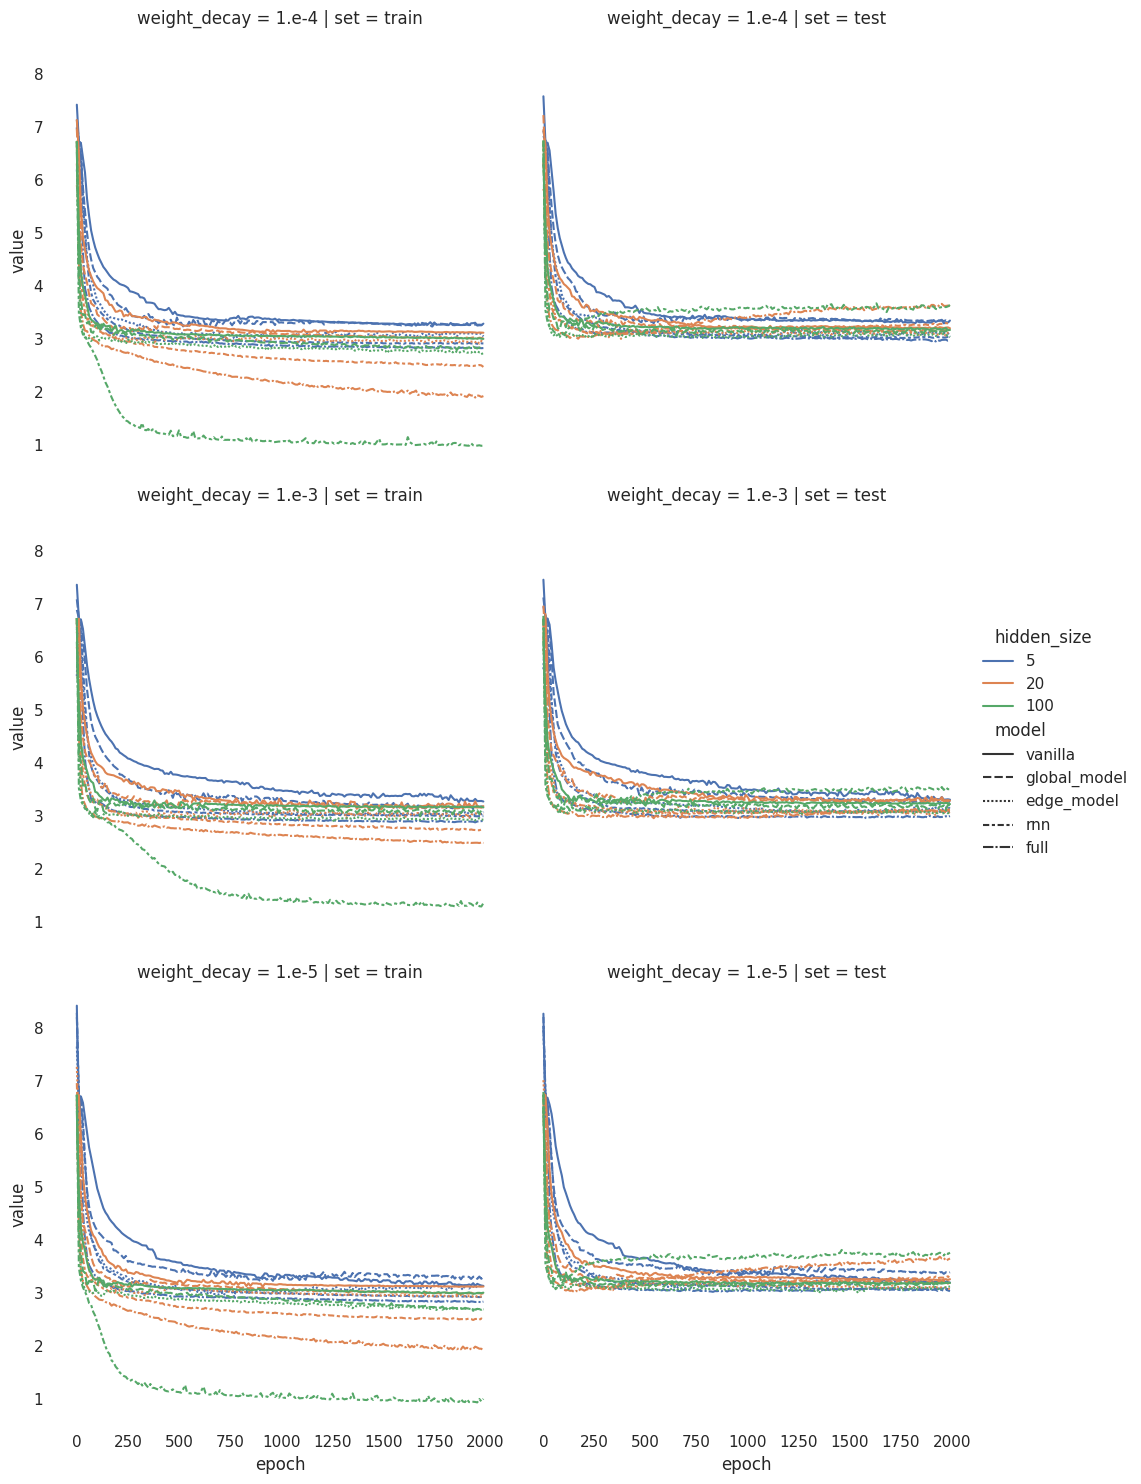

In [ ]:
metric_name = 'mean_absolute_error'

selection = {
    'strategy': 'greedy',
    'hidden_size': '20',
    'model': 'edge_model',
    'weight_decay': '1.e-4'
}

focus = ['hidden_size', 'model', 'weight_decay']

for f in focus:
    selection.pop(f)


w1 = pd.concat(
    (metrics_df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

w2 = (
    (metrics_df['name'] == metric_name) 
)

fg = sns.relplot(data=metrics_df[w1 & w2].copy(), x='epoch', hue=focus[0], style=focus[1] if len(focus) >= 2 else None, y='value', col='set', row=focus[2] if len(focus) >= 3 else None, kind='line', ci=None)